# ANÁLISE EXPLORATÓRIA DAS PALAVRAS MAIS USADAS NAS LETRAS DAS MÚSICAS DE FUNK

## Importando Bibliotecas

In [1]:
# Data Science
import pandas as pd
import matplotlib.pyplot as plt

# WebScraping
import requests
from bs4 import BeautifulSoup

# StopWords (Palavras para Processamento de Linguagem Natural)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oper1.clopes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## WEBSCRAPING

### FUNÇÃO AUXILIAR: GET_ANCHORS
RETORNA UMA LISTA ORDENADA DE ANCHORS CONTENDO LINKS DE MÚSICAS MAIS ACESSADAS CATEGORIZADAS POR GÊNERO MUSICAL

In [2]:
# Função para resgatar os anchors da lista ordenada contendo dados das músicas mais acessadas por gênero no URL fonte.
# Fonte: https://www.letras.mus.br/
# Data de Criação: 20/12/2022

def get_anchors(genre):
    # URL da fonte de dados
    url = f'https://www.letras.mus.br/mais-acessadas/{str(genre).lower()}/'
    
    # Resgata o conteúdo HTML da página
    page_content = requests.get(url).content
    
    # Converte o conteúdo HTML num objeto BeautifulSoup
    soup = BeautifulSoup(page_content, "html.parser")
    
    # Resgata os anchors a partir dos itens da primeira lista ordenada do site
    anchors = [li.find('a') for li in soup.find('ol') if li.text!=' ']
    
    # Retorna o resultado
    return anchors

### FUNÇÃO AUXILIAR: GET_LYRIC_WORDS
RETORNA UMA LISTA DE PALAVRAS, ÚNICAS OU NÃO, A PARTIR DE UM URL DE REFERÊNCIA DE UMA MÚSICA.

In [3]:
# Função para resgatar as palavras contidas na letra de uma música de forma única ou não.
# Fonte: https://www.letras.mus.br/
# Data de Criação: 20/12/2022

def get_lyric_words(href, unique_words=True):

    from string import punctuation
    words = []
    
    # Define a URL da fonte de dados
    url = f"https://www.letras.mus.br{href}"
    
    # Resgata o conteúdo HTML da página
    page_content = requests.get(url).content
    
    # Converte o conteúdo HTML num objeto BeautifulSoup
    soup = BeautifulSoup(page_content, "html.parser")
    
    # Resgata a div da classe 'cnt-letra'
    div = soup.find('div', 'cnt-letra')
    
    # Resgata os parágraphos
    paragraphs = div.find_all('p')

    for paragraph in paragraphs:
        for content in paragraph.contents:
            # Pula para o próximo loop caso o conteúdo esteja em branco
            if len(content) == 0:
                continue

            # Remove as quebras de linha
            processed_content = str(content).replace('<br>', '\n').replace('<br/>', '\n').replace('</br>','\n')

            # Remove Caracteres de Pontuação
            for c in punctuation:
                processed_content = processed_content.replace(c, '\n')

            # Transforma os caracteres em lower case
            processed_content = processed_content.lower()

            # Verifica a condição da variável unique_words
            if unique_words:
                # True: Adiciona palavras à lista de palavras
                for word in processed_content.split():
                    if word not in words:
                        words.append(word)
                    else:
                        continue
            else:
                # False: Adiciona palavras únicas à lista de palavras
                for word in processed_content.split():
                    words.append(word)

    return words

### RESGATANDO DADOS

In [4]:
# Resgata os anchors das melhores músicas do gênero 'funk'
genre = 'funk'
anchors = get_anchors(genre)

In [5]:
# Armazena todas as palavras das 100 melhores músicas resgatadas na variável word_list
n_top_music = 100
word_list = []
for i in range(n_top_music):
    for word in get_lyric_words(anchors[i]['href'], unique_words=True):
        word_list.append(word)

In [6]:
# Converte a lista de palavras num dataframe contando as ocorrências de cada palavra e exibe o resultado
df = pd.Series(word_list).value_counts().reset_index().rename(columns={'index': 'word', 0: 'count'})

## DATAFRAME

In [7]:
# Topo do frame
display(df.head())

,word,count
0,que,95
1,e,94
2,é,94
3,de,93
4,o,91


In [8]:
# Informações sobre o frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4561 entries, 0 to 4560
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    4561 non-null   object
 1   count   4561 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 71.4+ KB


In [9]:
# Descrição de colunas numéricas
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
count,4561.0,3.425345,7.488395,1.0,1.0,1.0,3.0,95.0


In [10]:
# Contagem de registros nulos por coluna
display(df.isnull().sum())

word     0
count    0
dtype: int64

In [11]:
# Número de registros únicos por coluna
display(df.nunique())

word     4561
count      71
dtype: int64

## ANÁLISE EXPLORATÓRIA

In [12]:
def univariate_barchart(x, y, title, xlabel, ylabel, xlabel_rotation=0, grid=False, barlabel=False,
                        fig_width=10, fig_heigth=5, dpi=80, barcolor='green'):
    # Define subplot
    fig, ax = plt.subplots(figsize=(fig_width,fig_heigth), dpi=dpi)

    # Grafico de barras
    plt.bar(x, y, color=barcolor)

    # Título e etiquetas do gráfico
    plt.title(title)
    plt.xlabel(xlabel)
    plt.xticks(rotation=xlabel_rotation)
    plt.ylabel(ylabel)
    
    # Grade
    if grid:
        ax.set_axisbelow(True)
        plt.grid(linestyle='dashed', color='lightgrey')

    # Etiqueta das barras
    if barlabel:
        ax.bar_label(ax.containers[0], label_type='edge')

    # Exibição
    plt.show()

In [13]:
# Filtrando StopWords
# StopWords informais também sejam filtradas

# Lista vazia definida para armazenar o index das palavras consideradas stopwords
index_list = []

# Adiciona a lista de stopwords definidas pela biblioteca nltk à variável sw
sw = stopwords.words('portuguese')

# Define uma lista de stopwords informais
informal_sw = ['pra', 'pro']

# Soma as listas formais e informais à uma única lista
new_sw = sw + informal_sw

# Verifica cada índice e palavra correspondente do frame
for index,word in zip(df.index, df['word']):
    
    # Caso a palavra esteja na lista de stopwords o index da linha desta palavra é armazenada na lista index_list
    if word in new_sw:
        index_list.append(index)

# Exclui as linhas a partir do index_list e armazena o novo frame num frame temporário
temp_df = df.drop(index_list).reset_index(drop=True)

# Exbie o cabeçalho resultado
display(temp_df.head())

,word,count
0,vai,67
1,tá,66
2,vou,58
3,tô,48
4,quer,45


In [14]:
# Separando as top 15 palavras com maior número de repetições e atribuindo o restante à linha "*outras"

n_top_words = 15

others_count = temp_df['count'][temp_df.index > n_top_words].sum()

others = {
    'word': ['*outras'],
    'count': [others_count]
}

new_df = pd.concat([temp_df.head(n_top_words),pd.DataFrame(others)], ignore_index=True)
display(new_df)

,word,count
0,vai,67
1,tá,66
2,vou,58
3,tô,48
4,quer,45
5,bem,43
6,hoje,43
7,vida,41
8,faz,40
9,sei,39


In [15]:
# Definindo Configurações de Plotagem
x = new_df['word']
y = new_df['count']
title = f"CONTAGEM DE PALAVRAS NAS {n_top_music} MÚSICAS DE \"{genre.upper()}\" MAIS ACESSADAS"
xlabel = "PALAVRA"
ylabel = "CONTAGEM"
xlabel_rotation = 0
grid = True
barlabel = True
fig_width = 15
fig_heigth = 7
dpi = 80
barcolor = 'green'

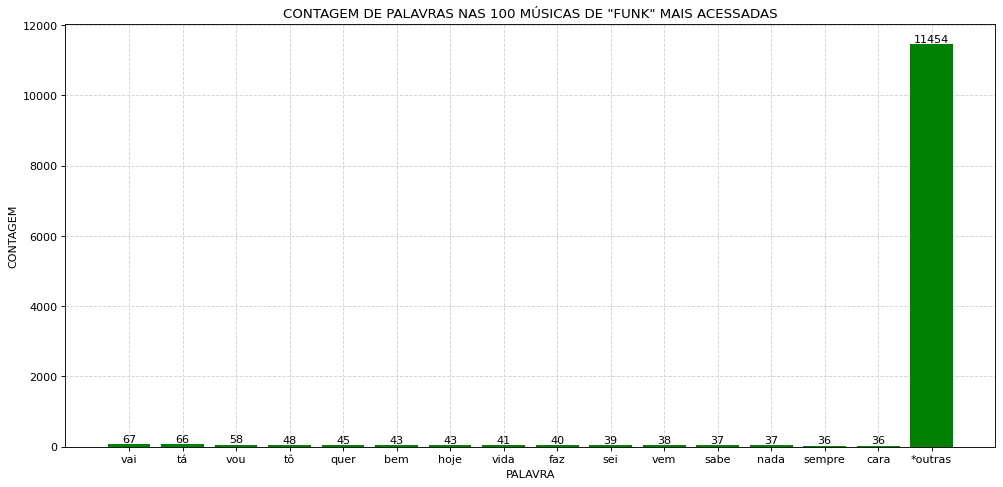

In [16]:
# Exibindo Resultados
univariate_barchart(x, y, title, xlabel, ylabel, xlabel_rotation, grid, barlabel, fig_width, fig_heigth, dpi, barcolor)

Considerações:
* Das 100 músicas mais acessadas, 67 contém a palavra "vai", sendo a palavra que mais se repete entre todas;
* As 5 palavras que mais se repetem nas músicas, do mais repetitivo para o menos repetitivo, são as palavras "vai", "tá", "vou", "tô" e "quer".
* Apesar de estar presente em 67 das 100 músicas, a palavra "vai" representa apenas 0,55% do total de repetições de palavras (12128) presentes nesta análise, revelando uma alta distribuição.